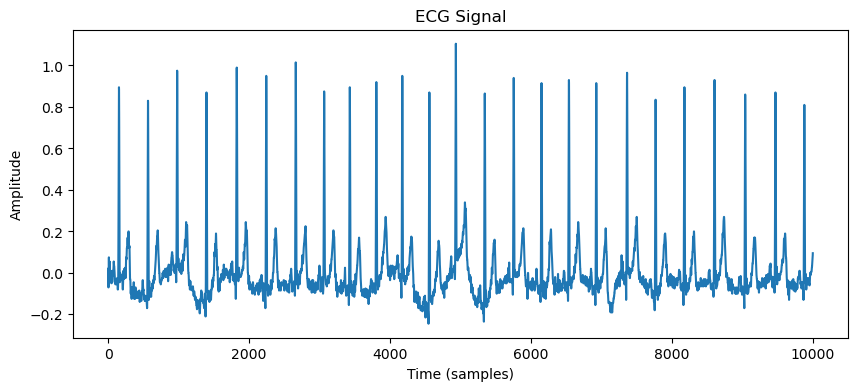

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [ ]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
# hr2 = pd.read_csv("file_resource/ecg-id-database-1.0.0/Person_03",names=["hr"])
# print(hr2.head())
# create new datatime index to hr2, every 0.5s

import wfdb
import matplotlib.pyplot as plt

# Specify the path to your downloaded data
path_to_data = 'file_resource/ecg-id-database-1.0.0/Person_03/'

# The record name is the filename without the extension
record_name = 'rec_1'

# Use the 'rdrecord' function to read the ECG data
record = wfdb.rdrecord(f'{path_to_data}/{record_name}')
# Plot the ECG data
plt.figure(figsize=(10, 4))
plt.plot(record.p_signal[:,1])
plt.title('ECG Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()
pd.DataFrame(record.p_signal[:,1],columns=["hr"]).to_csv("./P3_rec_1.csv")
hr2 = pd.DataFrame(record.p_signal[:,1],columns=["hr"])[0:10000]
# hr2["index"] = hr2.index


plt.figure(figsize=(10, 4))



In [ ]:

from torch import nn
import pandas as pd
import numpy as np
import torch
# X = [x for x in range(10000)]
# hr2_train = hr2[:8000]
# hr2_test = hr2[8000:9000]
# hr2_val = hr2[9000:]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# # hr2[0:800].plot()
# train_X = X[:8000]
# test_X = X[8000:9000]
# val_X = X[9000:]
# hr2_train_y = hr2[:8000]
# hr2_test_y = hr2[8000:9000]
# hr2_val_y = hr2[9000:]
df = hr2.copy()
df_train = df.loc[:8000].copy()
df_test = df.loc[8000:10000].copy()

target_sensor = "hr"
# features = list(df.columns.difference([target_sensor]))
features = ["hr"]
batch_size =32
forecast_lead = 450
forcast_step = 5
target = f"{target_sensor}_lead{forecast_lead}"

df[target] = df[target_sensor].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

df_train = df.loc[:8000].copy()
df_test = df.loc[8000:].copy()

print("Test set fraction:", len(df_train) / len(df_test))

target_mean = df_train[target].mean()
target_stdev = df_train[target].std()
# for c in df_train.columns:
#     mean = df_train[c].mean()
#     stdev = df_train[c].std()
#
#     df_train[c] = (df_train[c] - mean) / stdev
#     df_test[c] = (df_test[c] - mean) / stdev

Test set fraction: 5.161935483870968


In [ ]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features,sequence_head=10, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_head = sequence_head
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]-self.sequence_length

    def __getitem__(self, i):
        if i >= self.sequence_head - 1:
            i_start = i - self.sequence_head + 1
            x = self.X[i_start:(i + 1), :]

        else:
            padding = self.X[0].repeat(self.sequence_head - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)


        return x.to(device), self.y[i:i+self.sequence_length].to(device)



train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_head=forecast_lead,
    sequence_length=forcast_step,

)




In [ ]:
from torch.utils.data import DataLoader
torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

for i, (X, y) in enumerate(train_loader):
    print(X)
    # print(y)
    print()
    if i >3:break


tensor([[[ 0.0200],
         [ 0.0200],
         [ 0.0200],
         ...,
         [ 0.0200],
         [ 0.0200],
         [ 0.0200]],

        [[ 0.0200],
         [ 0.0200],
         [ 0.0200],
         ...,
         [ 0.0200],
         [ 0.0200],
         [-0.0400]],

        [[ 0.0200],
         [ 0.0200],
         [ 0.0200],
         ...,
         [ 0.0200],
         [-0.0400],
         [-0.0600]],

        ...,

        [[ 0.0200],
         [ 0.0200],
         [ 0.0200],
         ...,
         [ 0.0000],
         [ 0.0050],
         [ 0.0050]],

        [[ 0.0200],
         [ 0.0200],
         [ 0.0200],
         ...,
         [ 0.0050],
         [ 0.0050],
         [-0.0050]],

        [[ 0.0200],
         [ 0.0200],
         [ 0.0200],
         ...,
         [ 0.0050],
         [-0.0050],
         [-0.0150]]], device='cuda:0')

tensor([[[ 0.0200],
         [ 0.0200],
         [ 0.0200],
         ...,
         [-0.0050],
         [-0.0150],
         [-0.0250]],

        [[ 0.020

In [ ]:
torch.manual_seed(101)


train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
       sequence_head=forecast_lead,
    sequence_length=forcast_step,
)

test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=["hr"],
    sequence_head=forecast_lead,
    sequence_length=forcast_step,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([32, 450, 1])
Target shape: torch.Size([32, 5])


In [ ]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # 单向LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(input_seq, (h_0, c_0))
        pred = self.linear(output)
        pred = pred[:, -1, :]
        return pred



class ShallowRegressionRNN(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.rnn = nn.RNN(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(device)

        _, hn = self.rnn(x, h0)
        out = self.linear(hn).flatten()

        return out

In a 2-layer LSTM, the output of the first LSTM layer is used as input to the second LSTM layer. The LSTM layers are stacked on top of each other. The mathematical formulation of a single LSTM layer is as follows:

For each LSTM cell at time step $t$, given the input $x_t$ and the hidden state $h_{t-1}$ and cell state $c_{t-1}$ from the previous time step, the LSTM updates are computed as follows:

Forget gate: $f_t = \sigma(W_{f} \cdot [h_{t-1}, x_t] + b_{f})$
Input gate: $i_t = \sigma(W_{i} \cdot [h_{t-1}, x_t] + b_{i})$
Cell update: $\tilde{c}t = \tanh(W{c} \cdot [h_{t-1}, x_t] + b_{c})$
New cell state: $c_t = f_t * c_{t-1} + i_t * \tilde{c}_t$
Output gate: $o_t = \sigma(W_{o} \cdot [h_{t-1}, x_t] + b_{o})$
New hidden state: $h_t = o_t * \tanh(c_t)$
Here, $W$ terms denote weight matrices (for example, $W_{f}$ is the weight matrix for the forget gate), $b$ terms denote bias vectors (for example, $b_{f}$ is the bias vector for the forget gate), $*$ denotes element-wise multiplication, and $[h_{t-1}, x_t]$ denotes the concatenation of $h_{t-1}$ and $x_t$.

In a 2-layer LSTM, the hidden state output $h_t$ from the first LSTM layer would be used as the input $x_t$ to the second LSTM layer. The second LSTM layer would then perform the same set of updates. The final output of the 2-layer LSTM would be the hidden state $h_t$ from the second LSTM layer.

In [ ]:

num_hidden_units = 512
loss_function = nn.MSELoss()
model_lstm = ShallowRegressionLSTM(input_size=len(features), hidden_size=num_hidden_units, num_layers=1,output_size=forcast_step,batch_size=batch_size)
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

# loss_function = RMSELoss()


In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.to(device)
    model.train()

    for X, y in data_loader:
        # print(X.shape)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss


print("Untrained test\n--------")
# test_model(test_loader, model, loss_function)

avg_loss = 1
model_lstm.to(device)

Untrained test
--------


ShallowRegressionLSTM(
  (lstm): LSTM(1, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=5, bias=True)
)

In [ ]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)
for ix_epoch in range(150):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model_lstm, loss_function, optimizer=optimizer)
    temp = test_model(test_loader, model_lstm, loss_function)
    if temp < avg_loss:
        avg_loss = temp
        torch.save(model_lstm.state_dict(), "model_lstm.pt")
    # if ix_epoch % 20 == 0:
    #     learning_rate = learning_rate * 0.6
    #     optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)
    #     print(learning_rate)
    print()

Epoch 0
---------
Train loss: 0.024825911995896604
Test loss: 0.020048350796432007

Epoch 1
---------


KeyboardInterrupt: 

In [ ]:
# save the model
# torch.save(model_lstm.state_dict(), "model_lstm.pt")

model_lstm.load_state_dict(torch.load("model_lstm.pt"))

<All keys matched successfully>

      hr_lead450  Model forecast
0      -0.018143       -0.006436
1      -0.016594       -0.006594
2      -0.015819       -0.006720
3      -0.015045       -0.006768
4      -0.015045       -0.006819
...          ...             ...
9545    0.010516             NaN
9546    0.011291             NaN
9547    0.012840             NaN
9548    0.013615             NaN
9549    0.015164             NaN

[9550 rows x 2 columns]


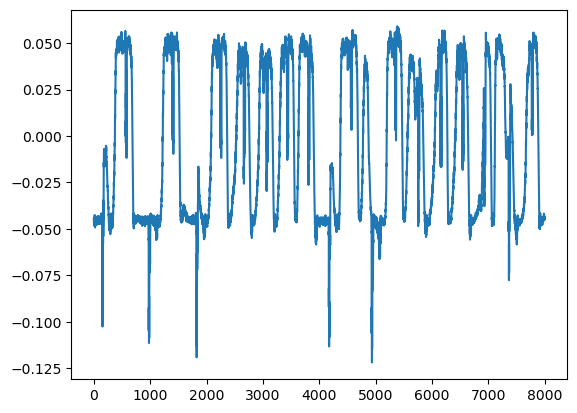

In [ ]:
def predict(data_loader, model):

    output = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        count = 0
        for X, _ in data_loader:
            if count % forcast_step != 0:
                count += 1
                continue
            y_star = model(X)
            output = torch.cat((output, y_star[0]), 0)
            count += 1
            # print(output)
            # break

    plt.plot(output.cpu().numpy())
    return output


train_eval_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
model_lstm.to(device)
ystar_col = "Model forecast"
train_predict = predict(train_eval_loader, model_lstm).cpu().numpy()
df_train=df_train[:8000]
df_train[ystar_col] = train_predict
# forcast_res = predict(test_loader, model_lstm).cpu().numpy()



df_out = pd.concat((df_train, df_test))[[target, ystar_col]]
for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean


print(df_out)


In [ ]:
# use last predict data to be the next input
def predict_window(data_loader, model, forecast_step=2000):
    output = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            # print(output.shape[0],X.shape[1])
            # if output.shape[0] >= forecast_step:
            #     break
            if output.shape[0] >= X.shape[1]:
                y_star = model(output[output.shape[0]-forecast_lead:].reshape(1,forecast_lead,1))
                output = torch.cat((output, y_star), 0)
                continue
            y_star = model(X)
            # print(y_star)
            output = torch.cat((output, y_star), 0)
            # print(output)
            # break
    return output
res = predict_window(test_loader, model_lstm).cpu().numpy()
print(res)
plt.plot(res)

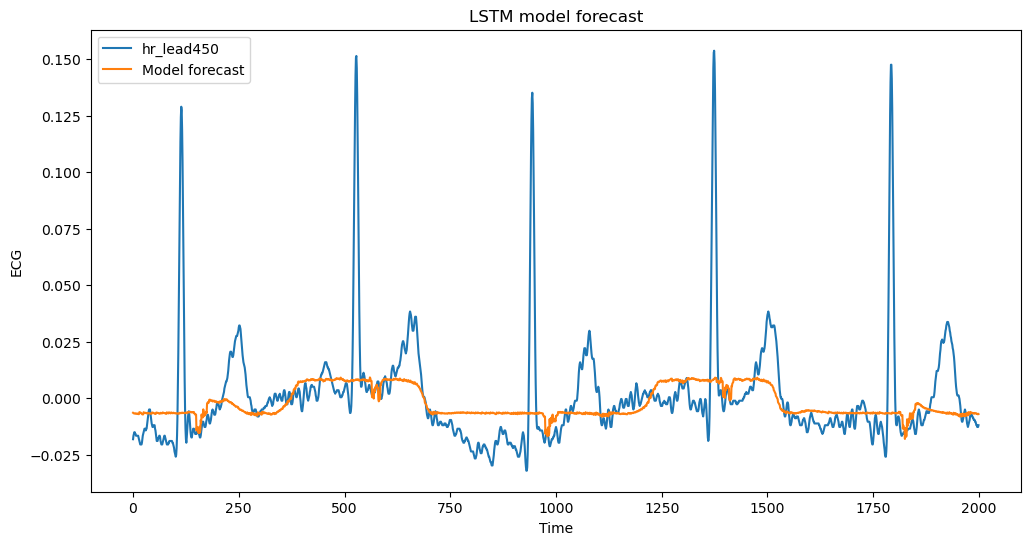

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error
fig, ax = plt.subplots(figsize=(12, 6))
df_out[0:2000].plot(ax=ax)
ax.set_title("LSTM model forecast")
ax.set_ylabel("ECG")
ax.set_xlabel("Time")
plt.show()

In [ ]:
# calculate the  error
# calculate the  AIC
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error

def calculate_aic(y_true, y_pred, num_params):
    mse = mean_squared_error(y_true, y_pred)
    aic = len(y_true) * np.log(mse) + 2 * num_params
    return aic

mse = mean_squared_error(df_out[target], df_out[ystar_col])
mae = mean_absolute_error(df_out[target], df_out[ystar_col])
r2 = r2_score(df_out[target], df_out[ystar_col])
mape = mean_absolute_percentage_error(df_out[target], df_out[ystar_col])
print(f"R2: {r2:.6f}")
print(f"MAPE: {mape:.6f}")
print(f"MAE: {mae:.6f} ")
print(f"RMSE: {np.sqrt(mse):.6f}")
print(f"mse: {mse:.6f}")
print(f"AIC: {calculate_aic(df_out[target], df_out[ystar_col], 1):.6f}")

In [ ]:
num_hidden_units = 128
# use sdg loss
loss_function = nn.MSELoss()
model = ShallowRegressionRNN(num_sensors=len(features), hidden_units=num_hidden_units)
model.to(device)
avg_loss = 1
# loss_function = RMSELoss()

In [ ]:
learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for ix_epoch in range(500):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    temp = test_model(test_loader, model, loss_function)
    if temp < avg_loss:
        avg_loss = temp
        torch.save(model.state_dict(), "model_RNN.pt")
    print()

In [ ]:
# save the model
# torch.save(model.state_dict(), "model_RNN.pt")

# load the model
model.load_state_dict(torch.load("model_RNN.pt"))
print(avg_loss)

In [ ]:
res = predict_window(test_loader, model).cpu().numpy()
print(len(res))
plt.plot(res)

In [ ]:
def predict(data_loader, model):

    output = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).cpu().numpy()
df_test[ystar_col] = predict(test_loader, model).cpu().numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

# for c in df_out.columns:
#     df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
df_out[8000:].plot(ax=ax)
ax.set_title("RNN model forecast")
ax.set_ylabel("ECG")
ax.set_xlabel("Time")
plt.show()


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error
mse = mean_squared_error(df_out[target], df_out[ystar_col])
mae = mean_absolute_error(df_out[target], df_out[ystar_col])
r2 = r2_score(df_out[target], df_out[ystar_col])
mape = mean_absolute_percentage_error(df_out[target], df_out[ystar_col])
print(f"R2: {r2:.6f}")
print(f"MAPE: {mape:.6f}")
print(f"MAE: {mae:.6f} ")
print(f"RMSE: {np.sqrt(mse):.6f}")
print(f"mse: {mse:.6f}")
print(f"AIC: {calculate_aic(df_out[target], df_out[ystar_col], 1):.6f}")
# aic_res = calaic(df_out[target], df_out[ystar_col], df_out.shape[1])
# print(f"AIC: {aic_res:.6f}")